In [2]:
import polars as pl
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from jormund import *

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

%matplotlib inline

setup_plots()

# Linear regression (Trend Line)  TODO

In [4]:
def l1_loss(b, w):
  loss = 0 * b
  for x, y in zip(x_data_list, y_data_list):
    f = w * x + b
    loss += np.abs(f - y)
  return loss / len(x_data_list)

In [ ]:
bs, ws = np.linspace(-1, 8, num=25), np.linspace(-3, 3, num=25)
b_grid, w_grid = np.meshgrid(bs, ws)
loss_grid = l1_loss(b_grid, w_grid)

# Non-Stationary Data

In [3]:
url =  "https://datahub.io/core/global-temp/r/monthly.csv"
global_temp = pl.read_csv(url, columns=["Year", "Mean"]).with_columns(pl.col("Year").str.strptime(pl.Date, "%Y-%m")) # Non-stationary

In [4]:
global_temp.head()

Year,Mean
date,f64
1850-01-01,-0.6746
1850-02-01,-0.3334
1850-03-01,-0.5913
1850-04-01,-0.5887
1850-05-01,-0.5088


In [8]:
global_temp = global_temp.with_columns(
    pl.col("Mean").shift(1).alias("lagged_mean")
)

In [9]:
# Covariance between 'Mean' and 'Year' features.
covariance = global_temp.select([
    ((pl.col("Mean") - pl.col("Mean").mean()) * (pl.col("Year") - pl.col("Year").mean())).mean()
]).to_numpy()[0][0]

print("Covariance between x and y:", covariance)

Covariance between x and y: 494560002830 milliseconds


In [10]:
# Autocovariance between 'Mean' and 'Year' features.
autocovariance = global_temp.select([
    ((pl.col("Mean") - pl.col("Mean").mean()) * (pl.col("lagged_mean") - pl.col("lagged_mean").mean())).mean()
]).to_numpy()[0][0]

print("Covariance between x and y:", autocovariance)

Covariance between x and y: 0.15302031503663005


In [11]:
# Pearson correlation between 'Mean' and 'Year' features.
correlation = global_temp.select([
    pl.corr("Mean", "Year")
]).to_numpy()[0][0]

print("correlation:", correlation)

correlation: 0.822883641462957


In [12]:
# Autocorrelation between 'Mean' and 'Year' features.
autocorrelation = global_temp.select([
    pl.corr("Mean", "lagged_mean")
]).to_numpy()[0][0]

print("Autocorrelation:", autocorrelation)

Autocorrelation: 0.9403948574019909


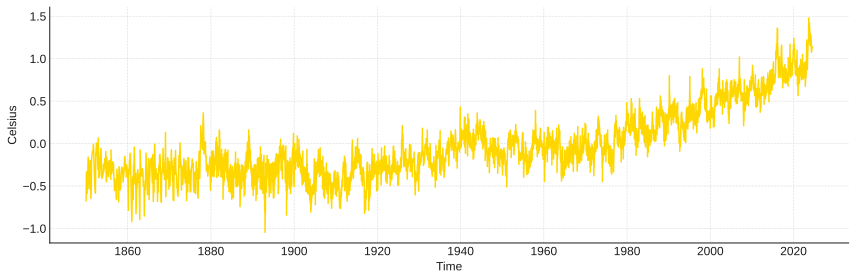

In [13]:
plt.figure(figsize=(12, 4))

plt.plot(global_temp["Year"], global_temp['Mean'], linestyle='-', color='gold')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Celsius', fontsize=12)

plt.tight_layout()
plt.show()

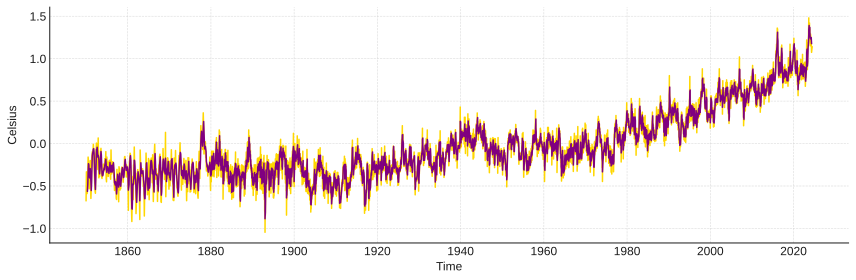

In [14]:
global_temp_seasonal = global_temp.slice(2, global_temp.height - 4) # To get complete seasons without shifts.
global_temp_seasonal = global_temp_seasonal.with_columns(
    pl.col("Mean").rolling_mean(window_size=3).alias("Rolling_Mean_3") # Moving average for 3 data points at ones for seasons.
) 

plt.figure(figsize=(12, 4))

plt.plot(global_temp["Year"], global_temp['Mean'], linestyle='-', color='gold')

plt.plot(global_temp_seasonal["Year"], global_temp_seasonal['Rolling_Mean_3'], label='Rolling Mean (Seasonal)', color='purple')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Celsius', fontsize=12)

plt.tight_layout()
plt.show()

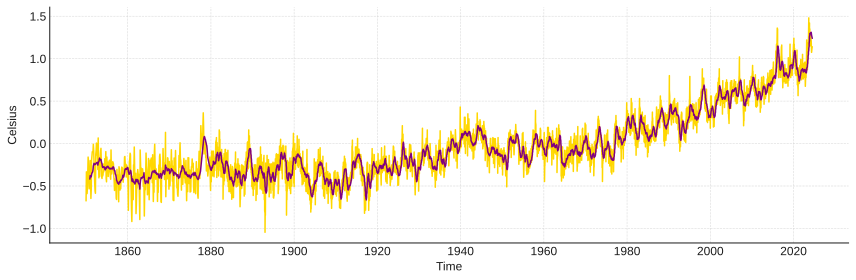

In [15]:
global_temp_seasonal = global_temp.with_columns(
    pl.col("Mean").rolling_mean(window_size=12).alias("Rolling_Mean_12") # Moving average for 12 data points at ones for an entire year.
)

plt.figure(figsize=(12, 4))

plt.plot(global_temp["Year"], global_temp['Mean'], linestyle='-', color='gold')

plt.plot(global_temp_seasonal["Year"], global_temp_seasonal['Rolling_Mean_12'], label='Rolling Mean (Yearly)', color='purple')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Celsius', fontsize=12)

plt.tight_layout()
plt.show()

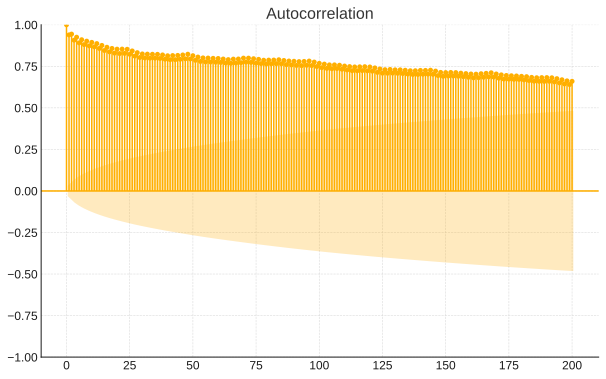

In [16]:
plot_acf(global_temp['Mean'], lags=200)
plt.show() # If the data is non-stationary then the decrease in the graph needs to be slow.

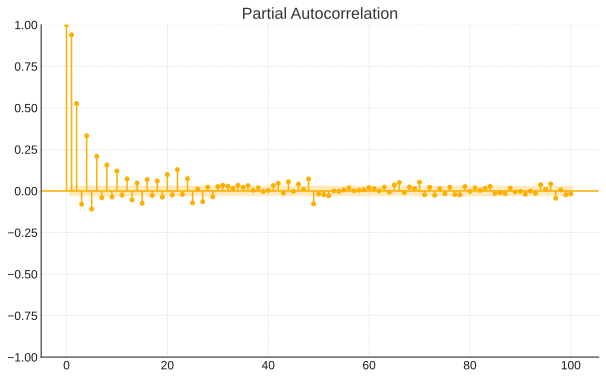

In [17]:
# Plot the PACF graph
plot_pacf(global_temp['Mean'], lags=100)  # 'ywm' method is stable for non-stationary series
plt.show()

In [18]:
# Perform ADF test on non_stationary data
adf_result = adfuller(global_temp['Mean'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1]) # Should be extremely small (commonly smaller than 0.05) for stationarity.

ADF Statistic: -1.1381033075100286
p-value: 0.6996401179554217


# Stationary Data

In [19]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
sunspot_count = pl.read_csv(url, columns=["Month", "Sunspots"]).with_columns(pl.col("Month").str.strptime(pl.Date, "%Y-%m")) # Stationary

In [20]:
sunspot_count.head()

Month,Sunspots
date,f64
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [21]:
sunspot_count = sunspot_count.with_columns(
    pl.col("Sunspots").shift(1).alias("lagged_sunspots")
)

In [22]:
# Covariance between 'Sunspots' and 'Month' features.
covariance = sunspot_count.select([
    ((pl.col("Sunspots") - pl.col("Sunspots").mean()) * (pl.col("Month") - pl.col("Month").mean())).mean()
]).to_numpy()[0][0]

print("Covariance between x and y:", covariance)

Covariance between x and y: 14562188813204 milliseconds


In [23]:
# Autocovariance between 'Sunspots' and 'lagged_sunspots' features.
autocovariance = sunspot_count.select([
    ((pl.col("Sunspots") - pl.col("Sunspots").mean()) * (pl.col("lagged_sunspots") - pl.col("lagged_sunspots").mean())).mean()
]).to_numpy()[0][0]

print("Covariance between x and y:", autocovariance)

Covariance between x and y: 1739.971111993931


In [24]:
# Pearson correlation between 'Sunspots' and 'Month' features.
correlation = sunspot_count.select([
    pl.corr("Sunspots", "Month")
]).to_numpy()[0][0]

print("correlation:", correlation)

correlation: 0.1565868061978657


In [25]:
# Autocorrelation between 'Sunspots' and 'lagged_sunspots' features.
autocorrelation = sunspot_count.select([
    pl.corr("Sunspots", "lagged_sunspots")
]).to_numpy()[0][0]

print("Autocorrelation:", autocorrelation)

Autocorrelation: 0.9217176860753832


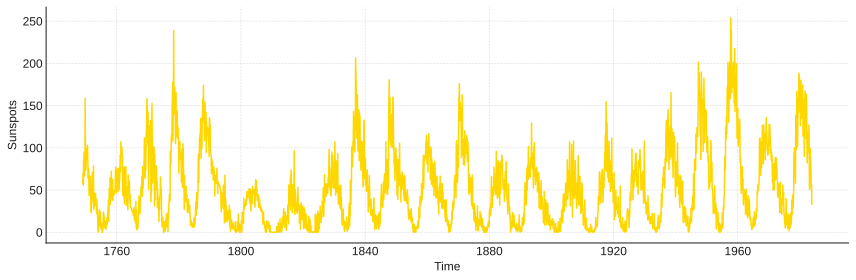

In [26]:
plt.figure(figsize=(12, 4))

plt.plot(sunspot_count['Month'], sunspot_count['Sunspots'], linestyle='-', color='gold')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Sunspots', fontsize=12)

plt.tight_layout()
plt.show()

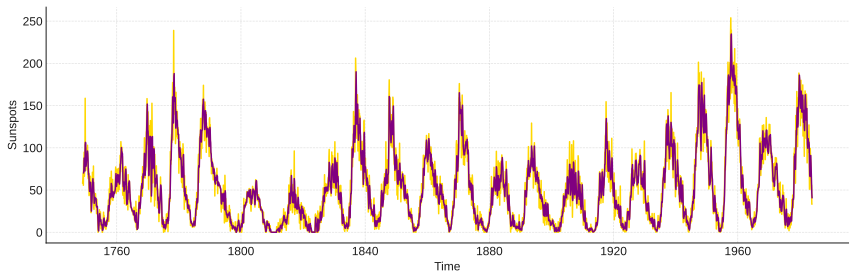

In [27]:
sunspot_count_seasonal = sunspot_count.slice(2, global_temp.height - 4) # To get complete seasons without shifts.
sunspot_count_seasonal = sunspot_count_seasonal.with_columns(
    pl.col("Sunspots").rolling_mean(window_size=3).alias("Rolling_sunspots_3") # Moving average for 3 data points at ones for seasons.
)

plt.figure(figsize=(12, 4))

plt.plot(sunspot_count['Month'], sunspot_count['Sunspots'], linestyle='-', color='gold')

plt.plot(sunspot_count_seasonal["Month"], sunspot_count_seasonal['Rolling_sunspots_3'], label='Rolling Mean (Seasonal)', color='purple')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Sunspots', fontsize=12)

plt.tight_layout()
plt.show()

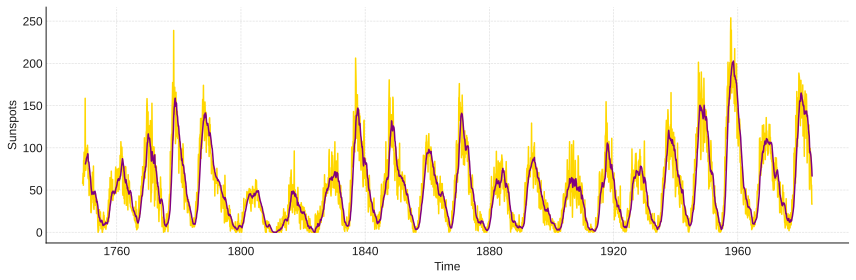

In [28]:
sunspot_count_seasonal = sunspot_count.with_columns(
    pl.col("Sunspots").rolling_mean(window_size=12).alias("Rolling_sunspots_3") # Moving average for 12 data points at ones for an entire year.
)

plt.figure(figsize=(12, 4))

plt.plot(sunspot_count['Month'], sunspot_count['Sunspots'], linestyle='-', color='gold')

plt.plot(sunspot_count_seasonal["Month"], sunspot_count_seasonal['Rolling_sunspots_3'], label='Rolling Mean (Yearly)', color='purple')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Sunspots', fontsize=12)

plt.tight_layout()
plt.show()

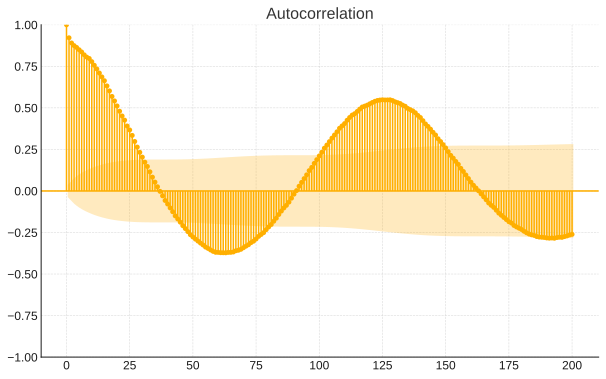

In [29]:
plot_acf(sunspot_count['Sunspots'], lags=200)
plt.show() # If the data is stationary then the decrease in the graph needs to be exponantial.

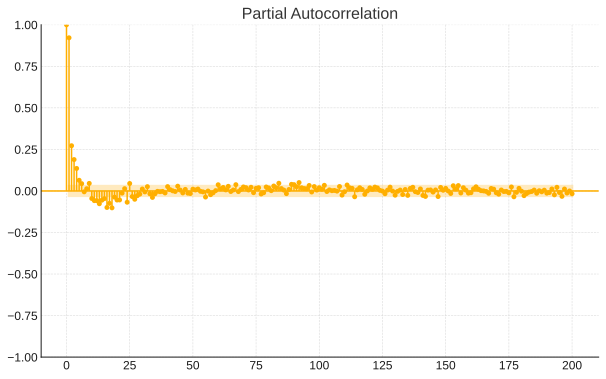

In [30]:
# Plot the PACF graph
plot_pacf(sunspot_count['Sunspots'], lags=200)  # 'ywm' method is stable for non-stationary series
plt.show()

In [22]:
# Perform ADF test on stationary data
adf_result = adfuller(sunspot_count['Sunspots'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1]) # Should be extremely small (commonly smaller than 0.05) for stationarity.

ADF Statistic: -9.567667511913076
p-value: 2.333452143866306e-16
